# Initialisation

In [1]:
!python --version

Python 3.10.14


In [2]:
# # See GPU info
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [3]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# # Install libraries not already included in colab
# !pip install ray[tune]
# !pip install optuna==2.9.1
# !pip install tslearn

## Imports

In [5]:
# Standard library imports
import glob
import os
import pickle
import pprint
import re
from collections import Counter

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.utils import resample
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.utils import to_time_series_dataset

# PyTorch and related imports
import torch
import torch
import torch_directml
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_packed_sequence, pad_sequence, pack_padded_sequence
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import DataLoader, Dataset, IterableDataset

## Constants

In [6]:
# Constants for easy reference and modification
COLS_TO_KEEP = [
    'vehicle_id', 'vehicle_type',
    'vehicle_speed', 'vehicle_angle',
    'vehicle_x', 'vehicle_y', 'vehicle_z',
    'timestep_time'
]

GROUPBY_COL = 'unique_id'

DATETIME_COL = 'datetime'

TARGET_COL = 'vehicle_type'

FEATURE_COLS = [
    'vehicle_speed',
    'vehicle_angle_sine', 'vehicle_angle_cosine',
    'vehicle_x', 'vehicle_y', 'vehicle_z'
]

SAVE_DIR = "/content/drive/MyDrive/RDO MDT stuff/vehicle_type_classification/melody_stuff"

dml = torch_directml.device()
print(dml)

privateuseone:0


## Functions and Class Definitions

# Raw Data

## Load raw data

In [7]:
!wget -nc https://standard-traffic-data.s3.us-east-2.amazonaws.com/most_0400_0600_1_5.csv
raw_df = pd.read_csv('most_0400_0600_1_5.csv', sep=';')

--2024-04-26 16:42:33--  https://standard-traffic-data.s3.us-east-2.amazonaws.com/most_0400_0600_1_5.csv
Resolving standard-traffic-data.s3.us-east-2.amazonaws.com (standard-traffic-data.s3.us-east-2.amazonaws.com)... 3.5.132.190, 3.5.130.150, 52.219.179.2, ...
Connecting to standard-traffic-data.s3.us-east-2.amazonaws.com (standard-traffic-data.s3.us-east-2.amazonaws.com)|3.5.132.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 212534013 (203M) [binary/octet-stream]
Saving to: ‘most_0400_0600_1_5.csv’

most_0400_0600_1_5.   2%[                    ]   5.54M  64.7KB/s    eta 23m 44s^C


## Inspect raw data

- `timestep_time` [s] – the current simulation time (0 corresponds to the beginning of the day)
- `vehicle_id` / `person_id` – a unique object identifier
- `vehicle_angle` / `person_angle` [°] – orientation of the object in navigational standard (0-360°)
- `vehicle_lane` – the ID of the lane the vehicle is currently moving onto
- `vehicle_pos` / `person_pos` [m] – running position of the object from the start of the current lane
- `vehicle_slope` / `person_slope` [°] – slope of the object lane at object position
- `vehicle_speed` / `person_speed` [m/s] – absolute speed of the object
- `vehicle_type` – the type of the vehicle (private vehicle, Uber, delivery truck etc.)
- `vehicle_x` / `person_x` [m] – absolute x coordinate / longitude of the object
- `vehicle_y` / `person_y` [m] – absolute y coordinate / latitude of the object
- `vehicle_z` / `person_z` [m] – elevation of the object
- `person_edge` – edge of the virtual footpath the person is moving on

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067350 entries, 0 to 2067349
Data columns (total 20 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestep_time  float64
 1   vehicle_angle  float64
 2   vehicle_id     object 
 3   vehicle_lane   object 
 4   vehicle_pos    float64
 5   vehicle_slope  float64
 6   vehicle_speed  float64
 7   vehicle_type   object 
 8   vehicle_x      float64
 9   vehicle_y      float64
 10  vehicle_z      float64
 11  person_angle   float64
 12  person_edge    object 
 13  person_id      object 
 14  person_pos     float64
 15  person_slope   float64
 16  person_speed   float64
 17  person_x       float64
 18  person_y       float64
 19  person_z       float64
dtypes: float64(15), object(5)
memory usage: 315.5+ MB


In [ ]:
raw_df.head()

,timestep_time,vehicle_angle,vehicle_id,vehicle_lane,vehicle_pos,vehicle_slope,vehicle_speed,vehicle_type,vehicle_x,vehicle_y,vehicle_z,person_angle,person_edge,person_id,person_pos,person_slope,person_speed,person_x,person_y,person_z
0,14400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14405.0,80.89,bus_M1:France.0,152927_1,12.10,3.01,0.00,bus,1085.69,197.96,54.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14410.0,71.94,bus_M1:France.0,152927_1,23.63,1.31,3.97,bus,1096.59,201.56,54.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14415.0,57.57,bus_M1:France.0,152927_1,57.99,0.66,8.49,bus,1126.83,217.57,55.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14420.0,32.10,bus_M1:France.0,152927_1,113.32,0.63,12.78,bus,1167.22,253.89,55.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
raw_df.describe()

,timestep_time,vehicle_angle,vehicle_pos,vehicle_slope,vehicle_speed,vehicle_x,vehicle_y,vehicle_z,person_angle,person_pos,person_slope,person_speed,person_x,person_y,person_z
count,2.067350e+06,1.228876e+06,1.228876e+06,1.228876e+06,1.228876e+06,1.228876e+06,1.228876e+06,1.228876e+06,838473.000000,837976.000000,838473.000000,837977.000000,838473.000000,838473.000000,838473.000000
mean,2.021132e+04,1.702282e+02,1.832031e+02,-6.081239e-01,5.878740e+00,4.394096e+03,2.036820e+03,9.745693e+01,161.218636,181.459266,-0.353450,7.413234,4313.035494,2069.419362,109.380626
std,9.779872e+02,9.915551e+01,5.781648e+02,5.173104e+00,6.913619e+00,1.581162e+03,1.031879e+03,1.157750e+02,100.731614,355.824890,6.752039,6.224017,1748.461993,1075.116513,120.228287
min,1.440000e+04,0.000000e+00,0.000000e+00,-8.873000e+01,0.000000e+00,-2.100000e-01,9.346000e+01,0.000000e+00,0.000000,0.000000,-90.000000,0.000000,-0.210000,93.460000,-0.080000
25%,1.952500e+04,8.179000e+01,1.553000e+01,-2.750000e+00,3.000000e-02,3.935520e+03,1.313255e+03,2.073000e+01,69.470000,13.380000,-2.250000,1.190000,3548.030000,1338.410000,26.250000
50%,2.035500e+04,1.968800e+02,4.360000e+01,0.000000e+00,2.180000e+00,4.513730e+03,1.859050e+03,6.108000e+01,157.550000,51.950000,0.000000,6.900000,4461.740000,1935.200000,67.800000
75%,2.102500e+04,2.323100e+02,1.335425e+02,1.090000e+00,1.233000e+01,5.155550e+03,2.665060e+03,1.069800e+02,240.100000,159.620000,1.530000,12.870000,5136.770000,2852.400000,126.250000
max,2.159500e+04,3.599900e+02,1.323421e+04,9.000000e+01,5.547000e+01,9.976570e+03,6.359290e+03,5.972100e+02,359.990000,4183.480000,90.000000,46.090000,9976.570000,6356.520000,575.200000


In [ ]:
# Check for duplicate rows
raw_df.duplicated().sum()

0

In [ ]:
# Check for null values
raw_df.isnull().sum()

timestep_time          0
vehicle_angle     838474
vehicle_id        838474
vehicle_lane      838474
vehicle_pos       838474
vehicle_slope     838474
vehicle_speed     838474
vehicle_type      838474
vehicle_x         838474
vehicle_y         838474
vehicle_z         838474
person_angle     1228877
person_edge      1228877
person_id        1228877
person_pos       1229374
person_slope     1228877
person_speed     1229373
person_x         1228877
person_y         1228877
person_z         1228877
dtype: int64

# Data Preprocessing

## 1. Keep only the relevant columns

- `vehicle_id` – a unique object identifier
- `timestep_time` [s] – the current simulation time (0 corresponds to the beginning of the day)
- `vehicle_speed` [m/s] – absolute speed of the object
- `vehicle_angle` [°] – orientation of the object in navigational standard (0-360°)
- `vehicle_x` [m] – absolute x coordinate / longitude of the object
- `vehicle_y` [m] – absolute y coordinate / latitude of the object
- `vehicle_z` [m] – elevation of the object
- `vehicle_type` – the type of the vehicle (private vehicle, Uber, delivery truck etc.)

In [ ]:
df = raw_df[COLS_TO_KEEP]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067350 entries, 0 to 2067349
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   vehicle_id     object 
 1   vehicle_type   object 
 2   vehicle_speed  float64
 3   vehicle_angle  float64
 4   vehicle_x      float64
 5   vehicle_y      float64
 6   vehicle_z      float64
 7   timestep_time  float64
dtypes: float64(6), object(2)
memory usage: 126.2+ MB


## 2. Drop duplicate rows

In [ ]:
# Check for duplicate rows
print(df.duplicated().sum())

837754


In [ ]:
# Drop duplicate rows
bef = len(df)
df = df.drop_duplicates()
aft = len(df)
print(f"{bef - aft} duplicate rows dropped. {aft} rows remain.")

# Sanity check
assert(df.duplicated().sum() == 0)

837754 duplicate rows dropped. 1229596 rows remain.


## 3. Drop rows with null values

In [ ]:
# Check for null values
print(df.isnull().sum())

vehicle_id       720
vehicle_type     720
vehicle_speed    720
vehicle_angle    720
vehicle_x        720
vehicle_y        720
vehicle_z        720
timestep_time      0
dtype: int64


In [ ]:
# Drop rows with null values
bef = len(df)
df = df.dropna()
aft = len(df)
print(f"{bef - aft} rows with null values dropped. {aft} rows remain.")

# Sanity check
assert(all(df.isnull().sum() == 0))

720 rows with null values dropped. 1228876 rows remain.


## 4. Create datetime col

In [ ]:
# Create a datetime column by converting UNIX format datetime column
df['datetime'] = pd.to_datetime(df['timestep_time'], unit='s')

In [ ]:
# Sort the dataset by vehicle_id and datetime to maintain chronological order
df = df.sort_values(by=['vehicle_id', DATETIME_COL]).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228876 entries, 0 to 1228875
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   vehicle_id     1228876 non-null  object        
 1   vehicle_type   1228876 non-null  object        
 2   vehicle_speed  1228876 non-null  float64       
 3   vehicle_angle  1228876 non-null  float64       
 4   vehicle_x      1228876 non-null  float64       
 5   vehicle_y      1228876 non-null  float64       
 6   vehicle_z      1228876 non-null  float64       
 7   timestep_time  1228876 non-null  float64       
 8   datetime       1228876 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 84.4+ MB


In [ ]:
df.head(10)

,vehicle_id,vehicle_type,vehicle_speed,vehicle_angle,vehicle_x,vehicle_y,vehicle_z,timestep_time,datetime
0,France:Italy.0,hw_trailer,0.00,74.69,75.76,2978.07,385.78,18000.0,1970-01-01 05:00:00
1,France:Italy.0,hw_trailer,3.77,75.90,86.77,2980.73,386.41,18005.0,1970-01-01 05:00:05
2,France:Italy.0,hw_trailer,7.79,78.24,116.17,2987.10,388.23,18010.0,1970-01-01 05:00:10
3,France:Italy.0,hw_trailer,11.98,83.16,167.19,2994.59,391.30,18015.0,1970-01-01 05:00:15
4,France:Italy.0,hw_trailer,16.58,93.25,239.67,2996.51,395.37,18020.0,1970-01-01 05:00:20
5,France:Italy.0,hw_trailer,20.39,106.63,331.35,2977.06,401.30,18025.0,1970-01-01 05:00:25
6,France:Italy.0,hw_trailer,24.18,115.81,435.77,2932.68,405.24,18030.0,1970-01-01 05:00:30
7,France:Italy.0,hw_trailer,27.59,111.34,555.70,2878.51,409.41,18035.0,1970-01-01 05:00:35
8,France:Italy.0,hw_trailer,27.64,100.30,688.87,2844.22,411.96,18040.0,1970-01-01 05:00:40
9,France:Italy.0,hw_trailer,27.53,98.34,824.14,2822.54,412.65,18045.0,1970-01-01 05:00:45


## 5. Create unique_id column
In some cases, the same vehicle_id might be reused for different vehicles, or the same vehicle_id might make different trips throughout its lifetime in the dataset. Thus, a unique_id column is created to distinguish these sequences.

In [ ]:
def assign_unique_ids(df, time_gap_threshold=7200):
    # Sort by 'vehicle_id' and 'datetime' to ensure the correct order
    df = df.sort_values(by=['vehicle_id', DATETIME_COL]).reset_index(drop=True)

    # Calculate the time difference between consecutive rows
    df['time_diff'] = df.groupby('vehicle_id')[DATETIME_COL].diff().dt.total_seconds().fillna(0.0)

    # Identify the start of a new sequence
    df['new_seq'] = df['time_diff'] > time_gap_threshold

    # Generate an incremental sequence identifier within each vehicle_id group
    df['seq_id'] = df.groupby('vehicle_id')['new_seq'].cumsum().astype(int)

    # Convert 'seq_id' to string and pad with leading zeros
    df['seq_id_str'] = df['seq_id'].astype(str).str.zfill(3)

    # Concatenate 'vehicle_id' with 'seq_id_str' to form 'unique_id'
    df['unique_id'] = df['vehicle_id'] + '_' + df['seq_id_str']

    # Drop all the interim columns created
    df = df.drop(columns=['time_diff', 'new_seq', 'seq_id', 'seq_id_str'])

    # Sort by 'unique_id' and 'datetime' to ensure the correct order
    df = df.sort_values(by=[GROUPBY_COL, DATETIME_COL]).reset_index(drop=True)

    return df

In [ ]:
df = assign_unique_ids(df)

In [ ]:
print(f"number of vehicle_ids: {df['vehicle_id'].nunique()}")
print(f"number of unique_ids: {df['unique_id'].nunique()}")

number of vehicle_ids: 6148
number of unique_ids: 6148


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228876 entries, 0 to 1228875
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   vehicle_id     1228876 non-null  object        
 1   vehicle_type   1228876 non-null  object        
 2   vehicle_speed  1228876 non-null  float64       
 3   vehicle_angle  1228876 non-null  float64       
 4   vehicle_x      1228876 non-null  float64       
 5   vehicle_y      1228876 non-null  float64       
 6   vehicle_z      1228876 non-null  float64       
 7   timestep_time  1228876 non-null  float64       
 8   datetime       1228876 non-null  datetime64[ns]
 9   unique_id      1228876 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 93.8+ MB


## 6. Drop rows belonging to unique_ids with only one data point

In [ ]:
# Calculate the count of rows for each unique_id
df['count'] = df.groupby(GROUPBY_COL)[GROUPBY_COL].transform('count')

# Filter out unique_ids with only one data point
df = df[df['count'] > 1]

# Drop interim column count
df = df.drop(columns=['count'])

# Sort by 'unique_id' and 'datetime' to ensure the correct order
df = df.sort_values(by=[GROUPBY_COL, DATETIME_COL]).reset_index(drop=True)

## 7. Impute missing/unknown labels

In [ ]:
df[TARGET_COL].nunique(), df[TARGET_COL].unique()

(31,
 array(['hw_trailer', 'hw_delivery', 'hw_passenger3', 'hw_truck',
        'hw_passenger2b', 'hw_coach', 'hw_motorcycle', 'hw_passenger1',
        'hw_passenger4', 'hw_passenger2a', 'bus', 'delivery', 'coach',
        'truck', 'trailer', 'avgbicycle', 'slowbicycle', 'fastbicycle',
        'motorcycle', 'taxi', 'moped', 'uber', 'passenger3', 'passenger4',
        'passenger2a', 'passenger1', 'passenger2b', 'emergency',
        'authority', 'army', 'train'], dtype=object))

In [ ]:
# In this case there are no missing or unknown labels, hence no imputation is needed.

## 8. Ensure that each unique_id has only one label

In [ ]:
# Calculate the number of unique labels for each unique_id
num_labels_per_group = df.groupby(GROUPBY_COL)[TARGET_COL].nunique()

# Filter to get unique_ids with more than one label
ids_w_more_than_one_label = num_labels_per_group[num_labels_per_group > 1].index.tolist()

print(f"number of unique_ids with more than one label: {len(ids_w_more_than_one_label)}")

number of unique_ids with more than one label: 0


In [ ]:
# Drop rows belonging to these unique_ids
bef = len(df)
df = df[~df[GROUPBY_COL].isin(ids_w_more_than_one_label)]
aft = len(df)
print(f"{bef - aft} rows belonging to unique_ids with more than one label dropped. {aft} rows remain.")

# Sort by 'unique_id' and 'datetime' to ensure the correct order
df = df.sort_values(by=[GROUPBY_COL, DATETIME_COL]).reset_index(drop=True)

0 rows belonging to unique_ids with more than one label dropped. 1228866 rows remain.


## 9. Feature engineering: convert vehicle_angle to sine and cosine components

`vehicle_angle` is in degrees, and its values range from 0 to 360, and is cyclical in nature. For example, 359 degrees and 1 degree are very close in terms of orientation, but numerically they are far apart.

By transforming an angle into sine and cosine components, we effectively map the cyclical feature onto a circle. This way, values that are close to each other on the cycle (like 1 degree and 359 degrees) are also close in their sine and cosine representations.

In [ ]:
df['vehicle_angle_sine'] = np.sin(np.radians(df['vehicle_angle']))
df['vehicle_angle_cosine'] = np.cos(np.radians(df['vehicle_angle']))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228866 entries, 0 to 1228865
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   vehicle_id            1228866 non-null  object        
 1   vehicle_type          1228866 non-null  object        
 2   vehicle_speed         1228866 non-null  float64       
 3   vehicle_angle         1228866 non-null  float64       
 4   vehicle_x             1228866 non-null  float64       
 5   vehicle_y             1228866 non-null  float64       
 6   vehicle_z             1228866 non-null  float64       
 7   timestep_time         1228866 non-null  float64       
 8   datetime              1228866 non-null  datetime64[ns]
 9   unique_id             1228866 non-null  object        
 10  vehicle_angle_sine    1228866 non-null  float64       
 11  vehicle_angle_cosine  1228866 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(3

## 10. Check for regular time intervals within each unique_id and resample if needed

In [ ]:
# Calculate the time difference between consecutive rows
df['time_diff'] = df.groupby(GROUPBY_COL)[DATETIME_COL].diff().dt.total_seconds()

# Check if all time differences within each group are the same, excluding the initial NA
df['regular_interval'] = df.groupby(GROUPBY_COL)['time_diff'].transform(lambda x: (x.dropna().nunique() == 1))

# Get unique_ids with irregular intervals
ids_w_irregular_intervals = df.loc[df['regular_interval'] == False, GROUPBY_COL].unique()

# Find out the most regular time interval
print(df['time_diff'].value_counts())

# Drop all the interim columns created
df = df.drop(columns=['time_diff', 'regular_interval'])

print(f"\n{len(ids_w_irregular_intervals)} out of {df[GROUPBY_COL].nunique()} unique_ids have irregular time intervals.")

time_diff
5.0     1222686
10.0         28
20.0          5
15.0          3
50.0          2
45.0          1
55.0          1
25.0          1
40.0          1
Name: count, dtype: int64

42 out of 6138 unique_ids have irregular time intervals.


In [ ]:
# Resample the data at a desired frequency
def resample_group(group, desired_freq='5S'):
    # Ensure datetime column is in proper datetime format
    group[DATETIME_COL] = pd.to_datetime(group[DATETIME_COL])

    # Check for duplicate timestamps within the group
    if group[DATETIME_COL].duplicated().any():
        raise ValueError("Duplicate timestamps found within a group!")

    # Set datetime as index
    group = group.set_index(DATETIME_COL)

    # Define custom aggregation: mean for numeric columns, first for non-numeric
    aggregation = {col: 'mean' if pd.api.types.is_numeric_dtype(group[col]) else 'first'
                   for col in group.columns}

    # Resample the data to the desired frequency using the defined aggregation
    group = group.resample(desired_freq).agg(aggregation)

    # Interpolate to fill missing values after resampling, separately handling numeric and non-numeric columns
    numeric_cols = group.select_dtypes(include=['number']).columns
    group[numeric_cols] = group[numeric_cols].interpolate()
    non_numeric_cols = group.select_dtypes(exclude=['number']).columns
    group[non_numeric_cols] = group[non_numeric_cols].fillna(method='ffill')

    # Reset index to bring 'datetime' back as a column
    group.reset_index(inplace=True)

    return group

In [ ]:
# Apply the function to each 'unique_id' group
resampled_df = df.groupby(GROUPBY_COL).apply(resample_group).reset_index(drop=True)

# Sort by 'unique_id' and 'datetime' to ensure the correct order
resampled_df = resampled_df.sort_values(by=[GROUPBY_COL, DATETIME_COL]).reset_index(drop=True)

In [ ]:
resampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228962 entries, 0 to 1228961
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   datetime              1228962 non-null  datetime64[ns]
 1   vehicle_id            1228962 non-null  object        
 2   vehicle_type          1228962 non-null  object        
 3   vehicle_speed         1228962 non-null  float64       
 4   vehicle_angle         1228962 non-null  float64       
 5   vehicle_x             1228962 non-null  float64       
 6   vehicle_y             1228962 non-null  float64       
 7   vehicle_z             1228962 non-null  float64       
 8   timestep_time         1228962 non-null  float64       
 9   unique_id             1228962 non-null  object        
 10  vehicle_angle_sine    1228962 non-null  float64       
 11  vehicle_angle_cosine  1228962 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(3

In [ ]:
# Sanity check
from pandas.testing import assert_frame_equal

# Assuming df and resampled_df are already defined DataFrames
# Set 'unique_id' as an index for efficient lookup
df.set_index('unique_id', inplace=True)
resampled_df.set_index('unique_id', inplace=True)

# Use set operations for more efficient creation of the list of IDs with regular intervals
set_all_ids = set(df.index.unique())
set_ids_w_irregular_intervals = set(ids_w_irregular_intervals)
ids_w_regular_intervals = list(set_all_ids - set_ids_w_irregular_intervals)

# Function to check equality of two DataFrames
def check_dataframes_equivalence(df1, df2):
    try:
        # Assert that the dataframes are equal, considering column order, index order, and data types
        assert_frame_equal(df1.sort_index(axis=1), df2.sort_index(axis=1), check_dtype=True)
        return True
    except AssertionError as e:
        print(f"Difference details: {e}")
        return False

# Loop through each unique_id that is expected to have regular intervals
for unique_id in ids_w_regular_intervals:
    # Extract the corresponding slices from each DataFrame
    df1 = df.loc[[unique_id]]
    df2 = resampled_df.loc[[unique_id]]

    # Check if the DataFrames are equivalent and handle the exception if they are not
    if not check_dataframes_equivalence(df1, df2):
        print(f"DataFrames do not match for {unique_id}")

# Loop through each unique_id that initially had irregular intervals
for unique_id in ids_w_irregular_intervals:
    # Extract the corresponding slices from each DataFrame
    df1 = df.loc[[unique_id]]
    df2 = resampled_df.loc[[unique_id]]

    # Check if the DataFrames are equivalent and handle the exception if they are not
    if check_dataframes_equivalence(df1, df2):
        print(f"DataFrames unexpectedly match for {unique_id}")

# Reset index
df.reset_index(inplace=True)
resampled_df.reset_index(inplace=True)

Difference details: DataFrame are different

DataFrame shape mismatch
[left]:  (248, 11)
[right]: (258, 11)
Difference details: DataFrame are different

DataFrame shape mismatch
[left]:  (103, 11)
[right]: (104, 11)
Difference details: DataFrame are different

DataFrame shape mismatch
[left]:  (188, 11)
[right]: (189, 11)
Difference details: DataFrame are different

DataFrame shape mismatch
[left]:  (224, 11)
[right]: (226, 11)
Difference details: DataFrame are different

DataFrame shape mismatch
[left]:  (194, 11)
[right]: (195, 11)
Difference details: DataFrame are different

DataFrame shape mismatch
[left]:  (125, 11)
[right]: (126, 11)
Difference details: DataFrame are different

DataFrame shape mismatch
[left]:  (199, 11)
[right]: (200, 11)
Difference details: DataFrame are different

DataFrame shape mismatch
[left]:  (165, 11)
[right]: (166, 11)
Difference details: DataFrame are different

DataFrame shape mismatch
[left]:  (266, 11)
[right]: (267, 11)
Difference details: DataFram

#### Save the resampled df at this point

In [ ]:
# Sort by 'unique_id' and 'datetime' to ensure the correct order
resampled_df = resampled_df.sort_values(by=[GROUPBY_COL, DATETIME_COL]).reset_index(drop=True)

# Save the resampled df as a .csv file
resampled_df.to_csv(f'{SAVE_DIR}/250424_2323H_resampled_vehicle_data.csv', index=False)
print("Resampled data saved as .csv file to Google Drive.")

Resampled data saved as .csv file to Google Drive.


# Clustering with TSLearn

### Preparing the data for clustering

#### Can skip

In [ ]:
# Load resampled data directly
resampled_df = pd.read_csv(f'{SAVE_DIR}/250424_2323H_resampled_vehicle_data.csv')
resampled_df[DATETIME_COL] = pd.to_datetime(df[DATETIME_COL])
resampled_df.info()

df = resampled_df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228962 entries, 0 to 1228961
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   unique_id             1228962 non-null  object        
 1   datetime              1228962 non-null  datetime64[ns]
 2   vehicle_id            1228962 non-null  object        
 3   vehicle_type          1228962 non-null  object        
 4   vehicle_speed         1228962 non-null  float64       
 5   vehicle_angle         1228962 non-null  float64       
 6   vehicle_x             1228962 non-null  float64       
 7   vehicle_y             1228962 non-null  float64       
 8   vehicle_z             1228962 non-null  float64       
 9   timestep_time         1228962 non-null  float64       
 10  vehicle_angle_sine    1228962 non-null  float64       
 11  vehicle_angle_cosine  1228962 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(3

In [ ]:
print(f"There are currently {df[TARGET_COL].nunique()} vehicle_types in the dataset.\nThese classes are:")
print(f"{df[TARGET_COL].unique()}")

There are currently 31 vehicle_types in the dataset.
These classes are:
['hw_trailer' 'hw_delivery' 'hw_passenger3' 'hw_truck' 'hw_passenger2b'
 'hw_coach' 'hw_motorcycle' 'hw_passenger1' 'hw_passenger4'
 'hw_passenger2a' 'bus' 'delivery' 'coach' 'truck' 'trailer' 'avgbicycle'
 'slowbicycle' 'fastbicycle' 'motorcycle' 'taxi' 'moped' 'uber'
 'passenger3' 'passenger4' 'passenger2a' 'passenger1' 'passenger2b'
 'emergency' 'authority' 'army' 'train']


In [ ]:
# Load and prepare your DataFrame
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values(by=['unique_id', 'datetime'], inplace=True)

# Calculate time differences in seconds
df['time_diff_seconds'] = df.groupby('unique_id')['datetime'].diff().dt.total_seconds().fillna(0)

# Calculate speed change (delta velocity)
df['vehicle_speed_change'] = df.groupby('unique_id')['vehicle_speed'].diff().fillna(0)

# Calculate acceleration as change in velocity over time
df['acceleration'] = df['vehicle_speed_change'] / df['time_diff_seconds']

# Handle potential divide by zero issues by replacing infinities and NaNs
df['acceleration'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['acceleration'].fillna(0, inplace=True)

In [ ]:
# Sort by 'unique_id' and 'datetime' to ensure the correct order
df = df.sort_values(by=[GROUPBY_COL, DATETIME_COL]).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228962 entries, 0 to 1228961
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   unique_id             1228962 non-null  object        
 1   datetime              1228962 non-null  datetime64[ns]
 2   vehicle_id            1228962 non-null  object        
 3   vehicle_type          1228962 non-null  object        
 4   vehicle_speed         1228962 non-null  float64       
 5   vehicle_angle         1228962 non-null  float64       
 6   vehicle_x             1228962 non-null  float64       
 7   vehicle_y             1228962 non-null  float64       
 8   vehicle_z             1228962 non-null  float64       
 9   timestep_time         1228962 non-null  float64       
 10  vehicle_angle_sine    1228962 non-null  float64       
 11  vehicle_angle_cosine  1228962 non-null  float64       
 12  time_diff_seconds     1228962 non-null  fl

In [ ]:
# # Save the resampled df as a .csv file
# df.to_csv(f'{SAVE_DIR}/260424_0043H_vehicle_data_for_clustering.csv', index=False)
# print("Resampled data saved as .csv file to Google Drive.")

Resampled data saved as .csv file to Google Drive.


#### Start here

In [7]:
# Load data directly
df = pd.read_csv(f'{SAVE_DIR}/260424_0043H_vehicle_data_for_clustering.csv')
df[DATETIME_COL] = pd.to_datetime(df[DATETIME_COL])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228962 entries, 0 to 1228961
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   unique_id             1228962 non-null  object        
 1   datetime              1228962 non-null  datetime64[ns]
 2   vehicle_id            1228962 non-null  object        
 3   vehicle_type          1228962 non-null  object        
 4   vehicle_speed         1228962 non-null  float64       
 5   vehicle_angle         1228962 non-null  float64       
 6   vehicle_x             1228962 non-null  float64       
 7   vehicle_y             1228962 non-null  float64       
 8   vehicle_z             1228962 non-null  float64       
 9   timestep_time         1228962 non-null  float64       
 10  vehicle_angle_sine    1228962 non-null  float64       
 11  vehicle_angle_cosine  1228962 non-null  float64       
 12  time_diff_seconds     1228962 non-null  fl

In [8]:
# Selecting features for clustering
features = ['vehicle_speed', 'vehicle_angle_sine', 'vehicle_angle_cosine', 'acceleration']  # Updated feature list

# List to hold time series data
time_series_data = []
unique_ids = df['unique_id'].unique()

# Group by 'unique_id'
grouped = df.groupby('unique_id')
# Extract time series data
time_series_data = [group[1][features].values for group in grouped]
# for uid in unique_ids:
#     temp_df = df[df['unique_id'] == uid]
#     if len(temp_df) > 1:  # Only consider series with more than one time point
#         series = temp_df[features].values
#         time_series_data.append(series)

# Convert list to TSLearn time series dataset
time_series_dataset = to_time_series_dataset(time_series_data)

# Resample time series to the same length
max_length = max(len(ts) for ts in time_series_dataset)
time_series_dataset = TimeSeriesResampler(sz=max_length).fit_transform(time_series_dataset)

### Clustering with n=31

In [ ]:
# Clustering with TimeSeriesKMeans
n_clusters = 31  # Number of clusters
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=True, n_jobs=-1)
labels = model.fit_predict(time_series_dataset)

# Assign cluster labels back to the original DataFrame
cluster_labels = pd.Series(labels, index=unique_ids)
df['cluster_label'] = df['unique_id'].map(cluster_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 6138 out of 6138 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_

3209.608 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1765.257 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1705.906 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1684.448 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1671.040 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1660.451 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1652.822 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1647.054 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1643.520 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1639.744 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1637.707 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1635.491 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1633.916 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1632.945 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1632.572 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1632.460 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1632.253 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1631.965 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1631.865 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1631.774 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1631.730 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1631.710 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1631.617 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1631.152 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1630.728 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1630.548 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1630.471 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

1630.471 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

Clustered data saved as .csv file to Google Drive.
cluster_label     0     1     2     3     4      5     6      7     8     9   \
vehicle_type                                                                   
army               0     0     0     0     0      0     0      0     0    28   
authority        191     0     0   588    92      0   639    113   907   352   
avgbicycle         0     0  2618     0     0      0     0      0     0     0   
bus                0     0   269  5164   144     73   415    125   535   956   
coach            122     0    24     0     0    264   448      0   123   370   
delivery         203     0   115   196   801    234  2876    281  1088   800   
emergency        136     0     0   276   736     88  1128      0   707  1125   
fastbicycle        0     0  4479     0     0      0     0      0     0     0   
hw_coach           0     0     0     0     0      0     0      0     0     0   
hw_delivery        0   501     0     0     0      0     0      0     

In [ ]:
# Sort by 'unique_id' and 'datetime' to ensure the correct order
df = df.sort_values(by=[GROUPBY_COL, DATETIME_COL]).reset_index(drop=True)
# Save the df as a .csv file
df.to_csv(f'{SAVE_DIR}/clustered_vehicle_data.csv', index=False)
print("Clustered data saved as .csv file to Google Drive.")

# Save the labels
with open(f'{SAVE_DIR}/labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

# Save the time_series_dataset
with open(f'{SAVE_DIR}/time_series_dataset.pkl', 'wb') as f:
    pickle.dump(time_series_dataset, f)

#### Results

In [ ]:
# Analyze the clustering results
cross_tab = pd.crosstab(df['vehicle_type'], df['cluster_label'])
print(cross_tab)

cluster_label     0     1     2     3     4      5     6      7     8     9   \
vehicle_type                                                                   
army               0     0     0     0     0      0     0      0     0    28   
authority        191     0     0   588    92      0   639    113   907   352   
avgbicycle         0     0  2618     0     0      0     0      0     0     0   
bus                0     0   269  5164   144     73   415    125   535   956   
coach            122     0    24     0     0    264   448      0   123   370   
delivery         203     0   115   196   801    234  2876    281  1088   800   
emergency        136     0     0   276   736     88  1128      0   707  1125   
fastbicycle        0     0  4479     0     0      0     0      0     0     0   
hw_coach           0     0     0     0     0      0     0      0     0     0   
hw_delivery        0   501     0     0     0      0     0      0     0     0   
hw_motorcycle      0   405     0     0  

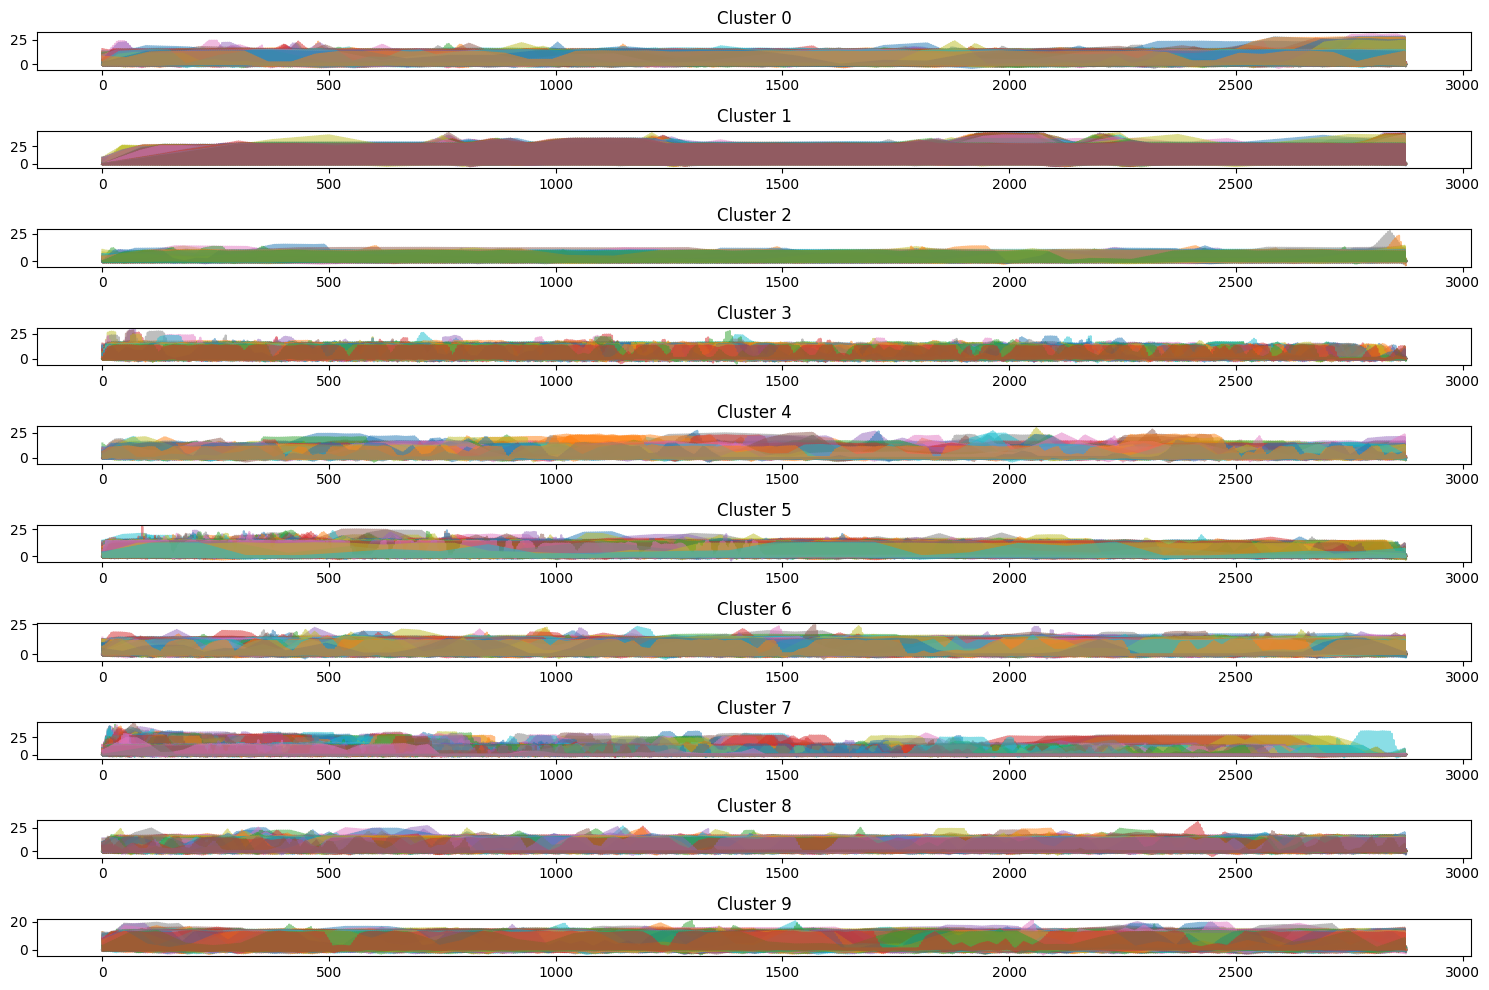

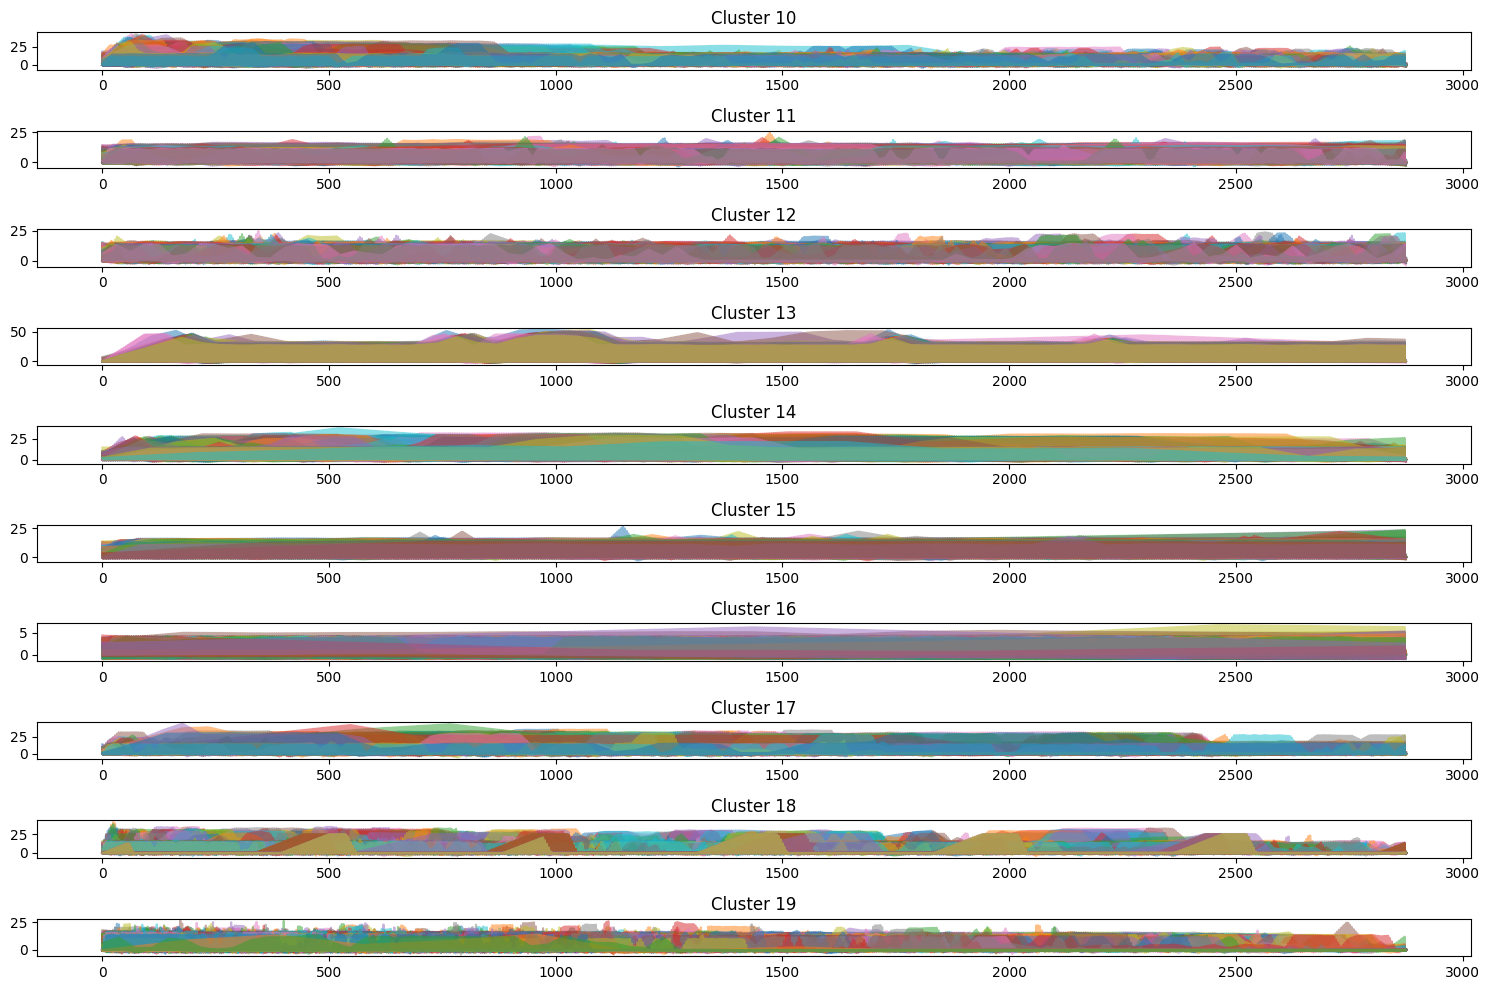

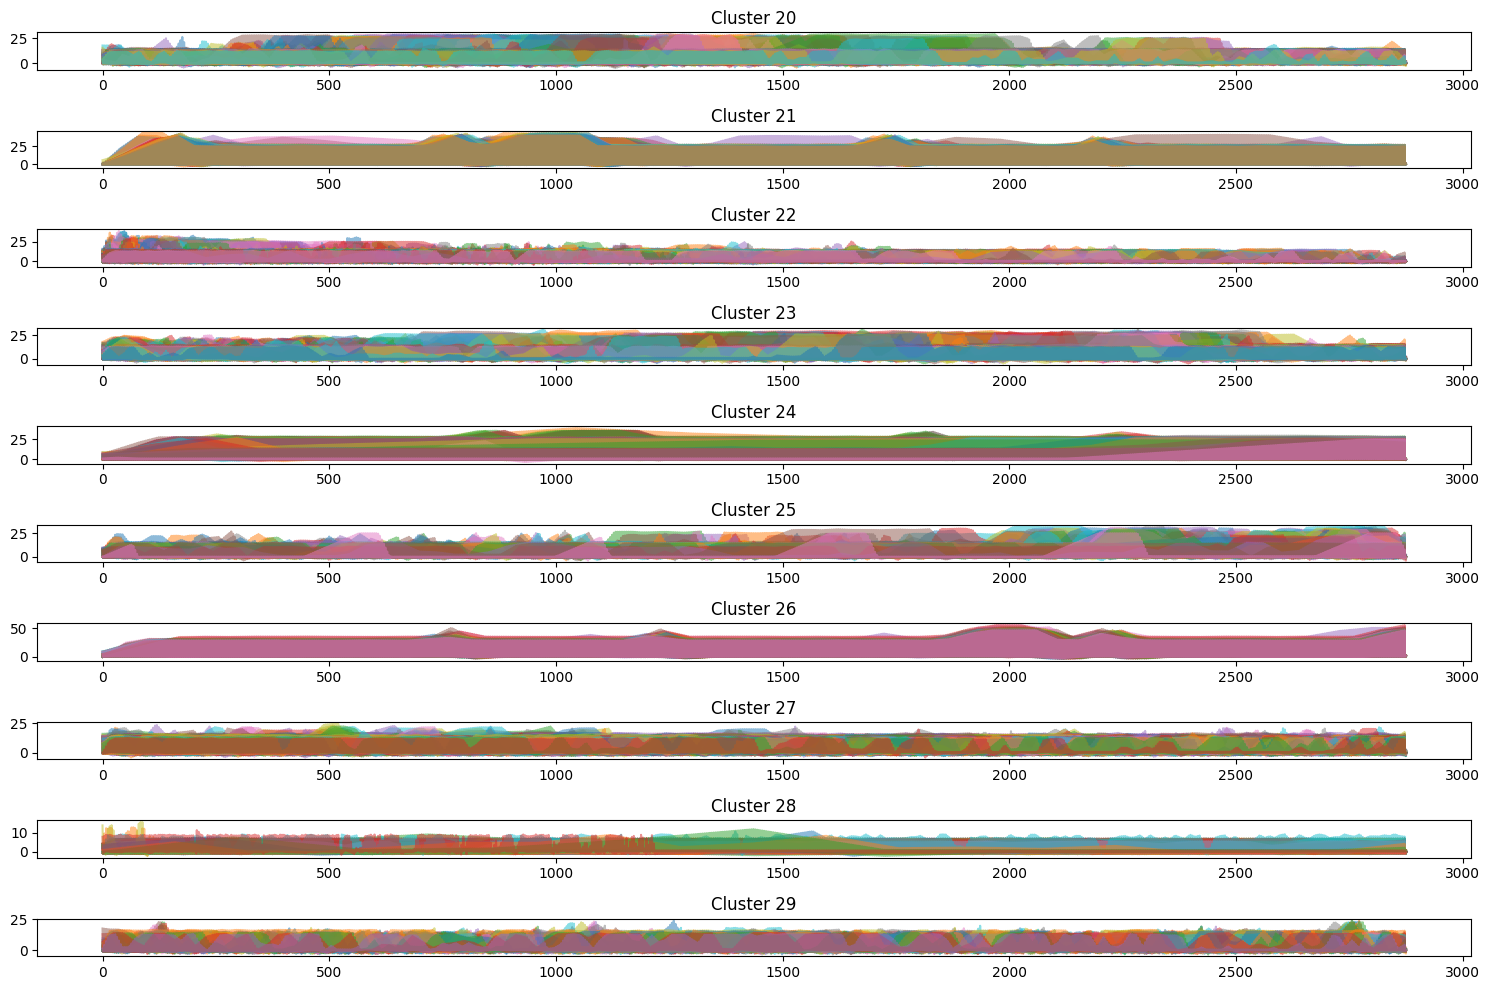

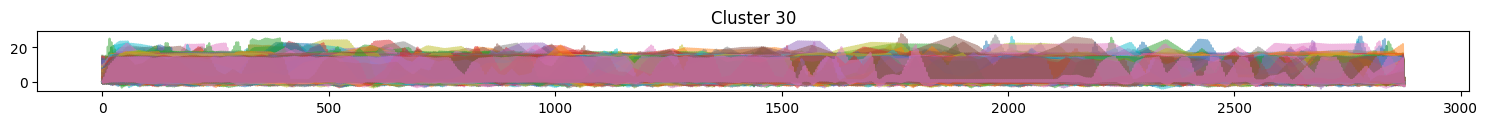

In [ ]:
clusters_per_figure = 10  # Adjust based on your preference and screen resolution

# Calculate the number of subplots needed
num_figures = (n_clusters + clusters_per_figure - 1) // clusters_per_figure

for i in range(num_figures):
    plt.figure(figsize=(15, 10))  # Adjust the figure size based on your needs
    for j in range(clusters_per_figure):
        cluster_index = i * clusters_per_figure + j
        if cluster_index >= n_clusters:
            break
        plt.subplot(clusters_per_figure, 1, j + 1)
        # Extract the indices for the current cluster from the labels
        indices = [idx for idx, label in enumerate(labels) if label == cluster_index]
        # Plot each time series in the cluster
        for index in indices:
            plt.plot(time_series_dataset[index].ravel(), label=f"Unique ID: {unique_ids[index]}", alpha=0.5)  # Reduce alpha to see overlapping series
        plt.title(f'Cluster {cluster_index}')
        plt.tight_layout()
    plt.show()

<ipython-input-25-e387473f7853>:28: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


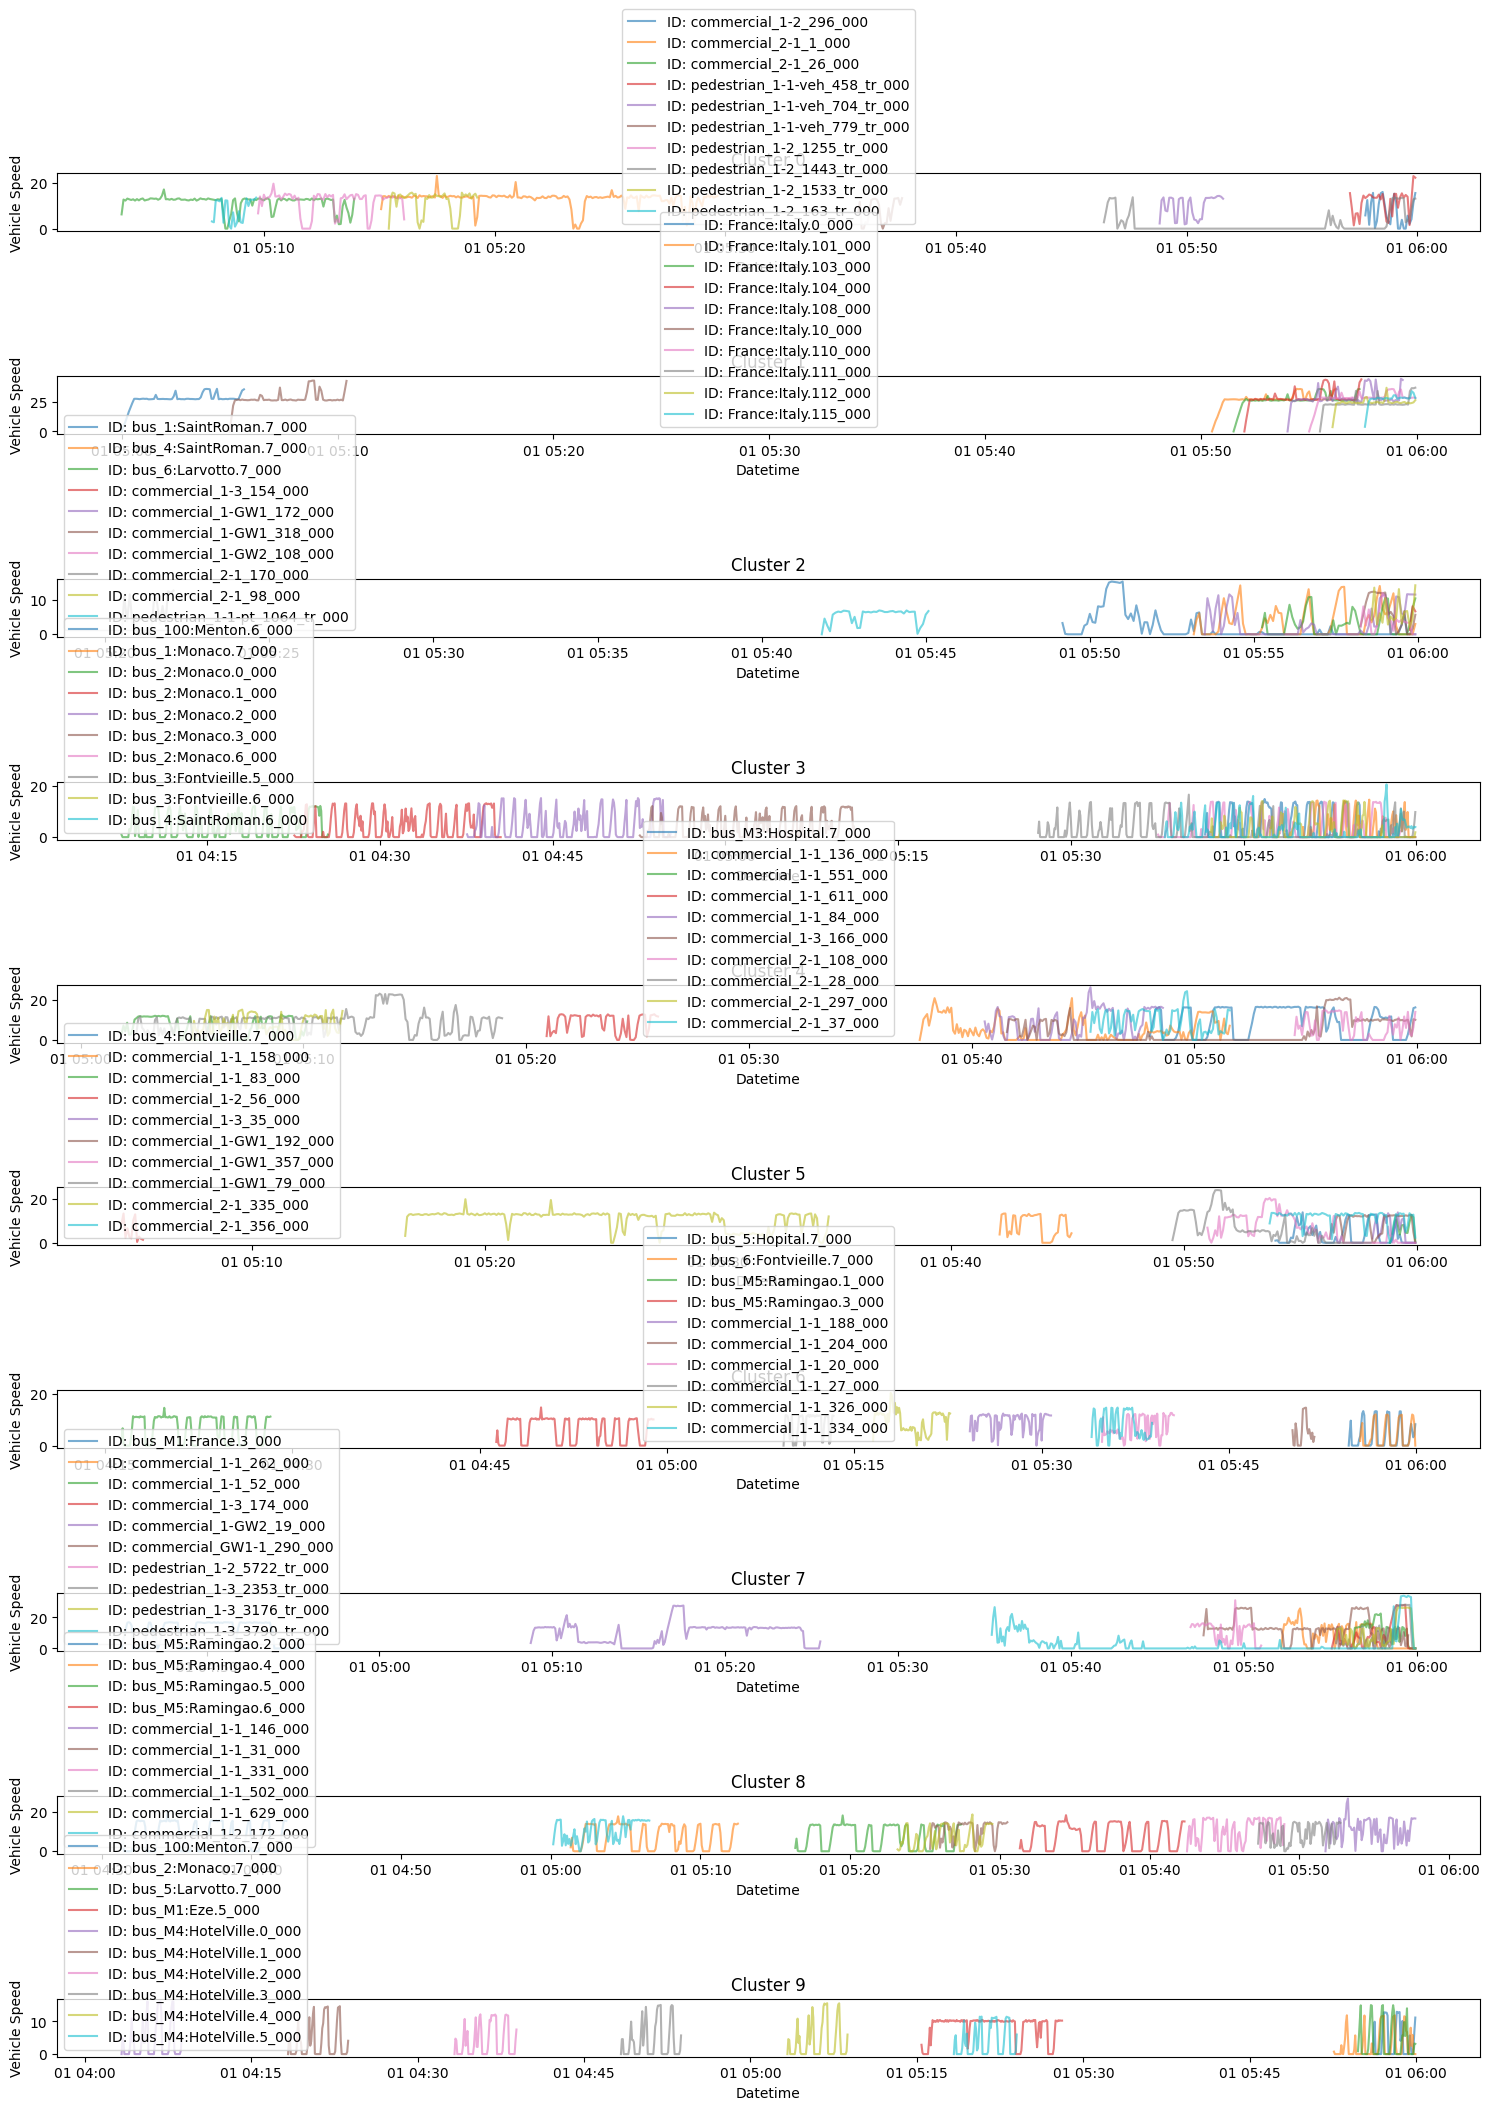

In [ ]:
# Define the number of clusters to plot (for readability, we might plot fewer clusters)
n_clusters_to_plot = 10  # adjust this based on how many clusters you want to display at once

# Set up a large figure to hold all subplots
plt.figure(figsize=(15, 20))  # adjust the figure size as necessary

# Loop through each cluster
for i in range(n_clusters_to_plot):
    ax = plt.subplot(n_clusters_to_plot, 1, i + 1)  # create a subplot for each cluster

    # Filter the DataFrame for the current cluster
    cluster_data = df[df['cluster_label'] == i]

    # Get unique IDs to plot a manageable number of time series
    unique_ids = cluster_data['unique_id'].unique()[:10]  # adjust the number sliced based on density

    for uid in unique_ids:
        # Filter data by unique_id
        data = cluster_data[cluster_data['unique_id'] == uid]

        # Plotting 'vehicle_speed' as an example time series feature
        plt.plot(data['datetime'], data['vehicle_speed'], label=f'ID: {uid}', alpha=0.6)

    plt.title(f'Cluster {i}')
    plt.xlabel('Datetime')
    plt.ylabel('Vehicle Speed')
    plt.legend()
    plt.tight_layout()

plt.show()

In [ ]:
# # Load the labels
# with open(f'{SAVE_DIR}/labels.pkl', 'rb') as f:
#     labels = pickle.load(f)

# # Load the time_series_dataset
# with open(f'{SAVE_DIR}/time_series_dataset.pkl', 'rb') as f:
#     time_series_dataset = pickle.load(f)

### Clustering with n=10

In [10]:
# Clustering with TimeSeriesKMeans
n_clusters = 10  # Number of clusters
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=True, n_jobs=-1)
labels = model.fit_predict(time_series_dataset)

# Assign cluster labels back to the original DataFrame
cluster_labels = pd.Series(labels, index=unique_ids)
df['cluster_label'] = df['unique_id'].map(cluster_labels)

In [ ]:
# Sort by 'unique_id' and 'datetime' to ensure the correct order
df = df.sort_values(by=[GROUPBY_COL, DATETIME_COL]).reset_index(drop=True)
# Save the df as a .csv file
df.to_csv(f'{SAVE_DIR}/clustered_vehicle_data.csv', index=False)
print("Clustered data saved as .csv file to Google Drive.")

# Save the labels
with open(f'{SAVE_DIR}/labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

# Save the time_series_dataset
with open(f'{SAVE_DIR}/time_series_dataset.pkl', 'wb') as f:
    pickle.dump(time_series_dataset, f)